# 05 - Regression Models in Seaborn

## Goal
Learn how to visualize regression relationships and diagnose fit quality using Seaborn:
- Linear regression with **`regplot()`**
- Residual diagnostics with **`residplot()`**
- Polynomial fits (`order=2`) and robust regression (`robust=True`)
- Logistic regression visualization (`logistic=True`)
- Conditioning / faceting with **`lmplot()`**

## What these plots *are* (and are not)
- Seaborn regression plots are primarily for **visual understanding** and quick diagnostics.
- They are not a replacement for a full modeling workflow (feature engineering, train/test split, evaluation metrics).

## Quick cheat sheet
| Task | Function | Typical usage |
|---|---|---|
| Scatter + best-fit line | `sns.regplot()` | `sns.regplot(data=df, x='x', y='y')` |
| Residual check | `sns.residplot()` | `sns.residplot(data=df, x='x', y='y')` |
| Polynomial curve | `sns.regplot(order=2)` | `sns.regplot(..., order=2)` |
| Robust regression | `sns.regplot(robust=True)` | Reduces outlier influence |
| Logistic regression curve | `sns.regplot(logistic=True)` | For binary `y` (0/1) |
| Faceted regression | `sns.lmplot()` | `sns.lmplot(..., col='category')` |

## Key parameters to remember
- `ci` (default 95): confidence interval for the regression estimate (set `ci=None` to hide).
- `scatter_kws`, `line_kws`: styling.
- `order`: polynomial order.
- `robust=True`: uses robust regression (less sensitive to outliers).
- `logistic=True`: fits a logistic curve (binary outcomes).


In [1]:
# Setup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', context='notebook')
np.random.seed(42)


## 0) Example dataset: synthetic e-commerce performance data
To make the regression examples realistic, this notebook builds a small **synthetic e-commerce dataset**.

### Scenario
- An e-commerce site runs campaigns across different `channel`s.
- The business tracks `sessions`, `ad_spend`, `discount_pct`, and outcomes like `order_value` and whether a session **converted**.

### Why synthetic?
It is easy to tweak relationships (linear, non-linear, outliers) to see how each regression plot behaves.


In [2]:
# Create a synthetic e-commerce dataset
n = 800
channels = np.random.choice(['Search', 'Social', 'Email', 'Affiliate'], size=n, p=[0.45, 0.30, 0.15, 0.10])
devices = np.random.choice(['Mobile', 'Desktop'], size=n, p=[0.65, 0.35])

# Sessions and spend
sessions = np.random.gamma(shape=2.0, scale=90.0, size=n).astype(int) + 10
ad_spend = np.random.lognormal(mean=3.3, sigma=0.55, size=n)  # positive, skewed

discount_pct = np.clip(np.random.normal(loc=12, scale=8, size=n), 0, 40)

# Channel multiplier affects overall performance
channel_multiplier = pd.Series(channels).map({
    'Search': 1.00,
    'Social': 0.85,
    'Email': 1.15,
    'Affiliate': 0.95,
}).to_numpy()

device_multiplier = pd.Series(devices).map({'Mobile': 0.95, 'Desktop': 1.05}).to_numpy()

# Order value: non-linear effect of discount (too high discount can reduce order value)
base_order_value = 45 + 0.08 * sessions + 7.5 * np.log1p(ad_spend)
nonlinear_discount_effect = 1.2 * discount_pct - 0.055 * (discount_pct ** 2)

noise = np.random.normal(0, 18, size=n)
order_value = (base_order_value + nonlinear_discount_effect) * channel_multiplier * device_multiplier + noise
order_value = np.clip(order_value, 5, None)

# Conversion probability (logistic): influenced by sessions quality proxy (channel), discount, and spend
logits = (
    -2.2
    + 0.010 * discount_pct
    + 0.0022 * np.sqrt(ad_spend)
    + 0.0006 * sessions
    + (channels == 'Email') * 0.35
    + (channels == 'Social') * (-0.20)
    + (devices == 'Desktop') * 0.15
)

p_convert = 1 / (1 + np.exp(-logits))
converted = (np.random.rand(n) < p_convert).astype(int)

# Revenue per session (0 when not converted)
revenue = converted * np.maximum(order_value + np.random.normal(0, 12, size=n), 0)

# Inject a few outliers: very large order value (e.g., bulk purchase)
outlier_idx = np.random.choice(np.arange(n), size=12, replace=False)
order_value[outlier_idx] *= np.random.uniform(2.5, 5.0, size=12)
revenue[outlier_idx] *= np.random.uniform(2.0, 4.0, size=12)

df = pd.DataFrame({
    'channel': channels,
    'device': devices,
    'sessions': sessions,
    'ad_spend': ad_spend,
    'discount_pct': discount_pct,
    'order_value': order_value,
    'converted': converted,
    'revenue': revenue,
})

df.head()


,channel,device,sessions,ad_spend,discount_pct,order_value,converted,revenue
0,Search,Desktop,102,33.540199,21.445127,76.549462,0,0.0
1,Affiliate,Mobile,70,49.404387,6.981492,52.760979,0,0.0
2,Social,Mobile,163,82.002419,12.361782,61.286617,0,0.0
3,Social,Mobile,87,47.609878,12.409583,83.326289,0,0.0
4,Search,Mobile,188,31.097260,7.985726,63.991985,0,0.0


In [3]:
# Quick sanity checks
print(df.shape)
print(df[['sessions', 'ad_spend', 'discount_pct', 'order_value', 'revenue']].describe().round(2))
print('Conversion rate:', df['converted'].mean().round(3))


(800, 8)
       sessions  ad_spend  discount_pct  order_value  revenue
count    800.00    800.00        800.00       800.00   800.00
mean     190.52     31.73         11.90        88.31    11.30
std      123.53     19.65          7.56        38.95    30.99
min       14.00      5.23          0.00        10.72     0.00
25%       98.00     18.38          6.10        71.14     0.00
50%      164.50     26.42         11.72        85.22     0.00
75%      250.25     39.44         16.69        99.03     0.00
max      829.00    234.96         37.94       570.88   212.99
Conversion rate: 0.129


## 1) Linear regression (`regplot`)
`regplot()` draws:
- a scatter plot of raw data
- a fitted regression line (default: linear)
- a confidence interval band (default: 95% CI)

### When it is useful
- Quick check: does `x` move with `y`?
- Rough sense of trend + variability

### Common parameters
- `ci=95` (default) or `ci=None`
- `scatter_kws={'alpha':0.4}` to reduce overplotting
- `line_kws={'color':'black'}` to highlight the fit


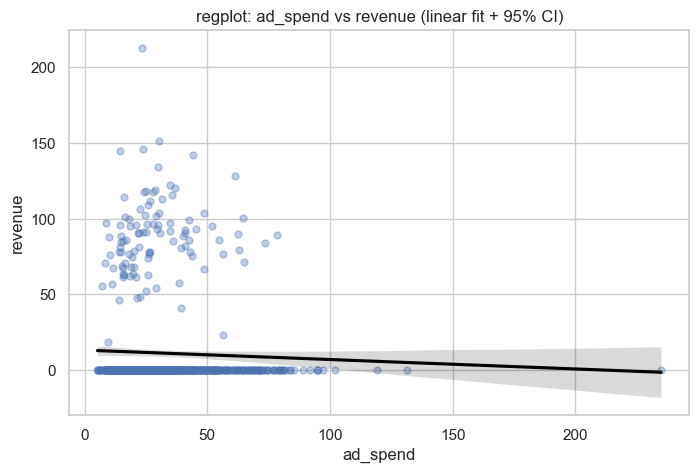

In [4]:
# Example: ad_spend vs revenue (linear fit)
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x='ad_spend',
    y='revenue',
    scatter_kws={'alpha': 0.35, 's': 25},
    line_kws={'color': 'black'}
)
plt.title('regplot: ad_spend vs revenue (linear fit + 95% CI)')
plt.show()


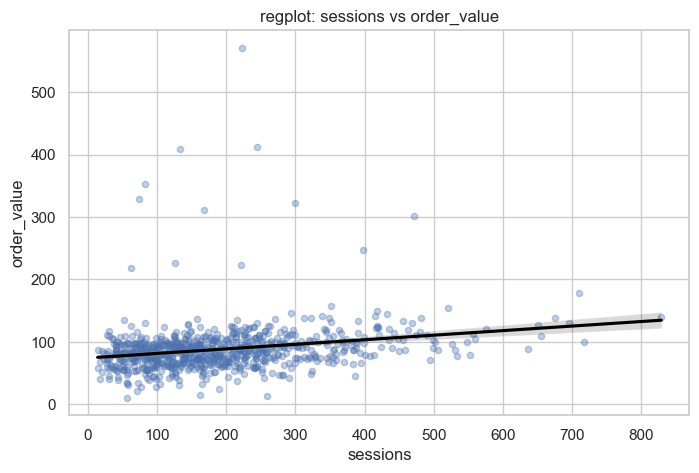

In [5]:
# Example: sessions vs order_value (linear fit)
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x='sessions',
    y='order_value',
    scatter_kws={'alpha': 0.35, 's': 20},
    line_kws={'color': 'black'}
)
plt.title('regplot: sessions vs order_value')
plt.show()


## 2) Residual plots (`residplot`)
A residual plot helps check if a linear model is appropriate.

### Interpretation
- Residuals should look like **random noise** around 0.
- Patterns suggest model issues:
  - Curvature → relationship is not linear
  - Fan shape → heteroscedasticity (variance changes with x)
  - Clusters → missing categorical factor (e.g., channel/device)


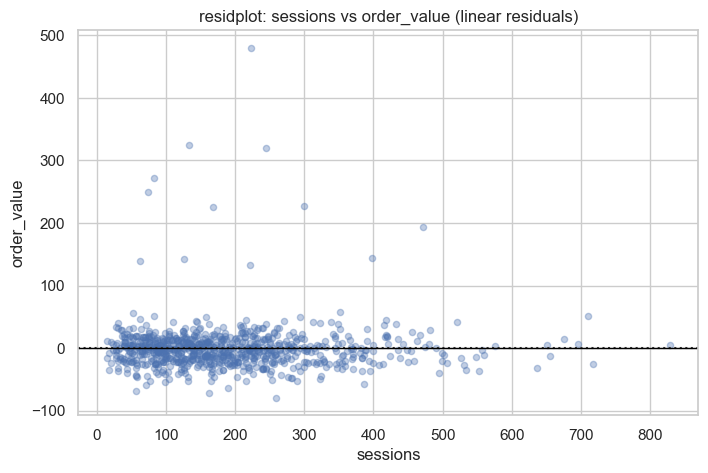

In [6]:
# Residuals for sessions -> order_value
plt.figure(figsize=(8, 5))
sns.residplot(
    data=df,
    x='sessions',
    y='order_value',
    scatter_kws={'alpha': 0.35, 's': 20}
)
plt.axhline(0, color='black', linewidth=1)
plt.title('residplot: sessions vs order_value (linear residuals)')
plt.show()


Tip: If residuals show a curve, try a polynomial (`order=2`) or a transformation (e.g., log/√).


## 3) Polynomial & robust regression

### Polynomial regression (`order=2`)
Use when the trend is curved. In this dataset, `discount_pct` affects `order_value` non-linearly.

### Robust regression (`robust=True`)
Useful when outliers exist (we injected a few large order values). Robust regression reduces outlier influence on the fitted line.


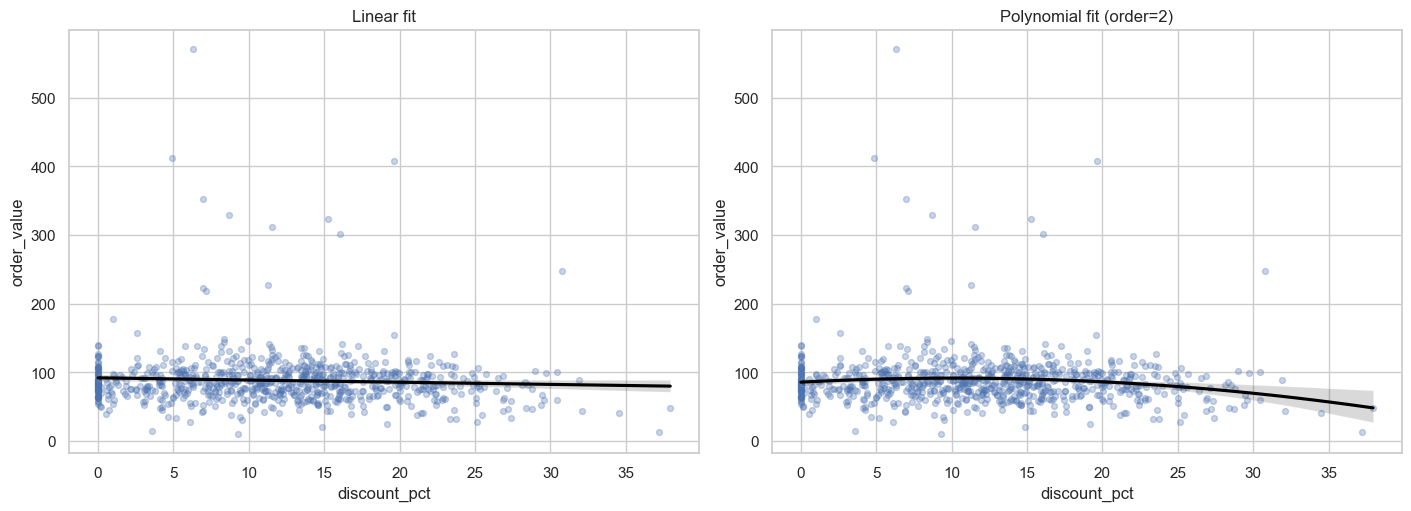

In [7]:
# Discount vs order_value: linear vs quadratic
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.regplot(
    data=df,
    x='discount_pct',
    y='order_value',
    scatter_kws={'alpha': 0.30, 's': 18},
    line_kws={'color': 'black'},
    ax=axes[0]
)
axes[0].set_title('Linear fit')

sns.regplot(
    data=df,
    x='discount_pct',
    y='order_value',
    order=2,
    scatter_kws={'alpha': 0.30, 's': 18},
    line_kws={'color': 'black'},
    ax=axes[1]
)
axes[1].set_title('Polynomial fit (order=2)')

plt.show()


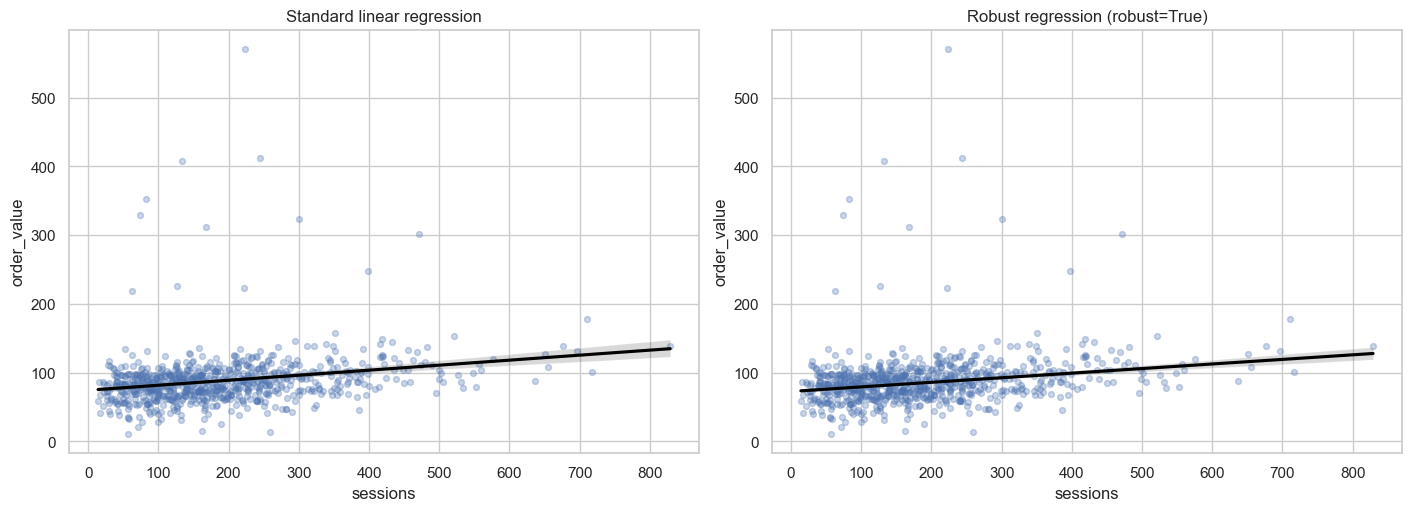

In [8]:
# Outliers: standard linear vs robust regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.regplot(
    data=df,
    x='sessions',
    y='order_value',
    scatter_kws={'alpha': 0.30, 's': 18},
    line_kws={'color': 'black'},
    ax=axes[0]
)
axes[0].set_title('Standard linear regression')

sns.regplot(
    data=df,
    x='sessions',
    y='order_value',
    robust=True,
    scatter_kws={'alpha': 0.30, 's': 18},
    line_kws={'color': 'black'},
    ax=axes[1]
)
axes[1].set_title('Robust regression (robust=True)')

plt.show()


## 4) Logistic regression visualization (`logistic=True`)
When the target is binary (0/1), a logistic regression curve is often more meaningful than a straight line.

### Typical e-commerce use case
- `converted` (0/1) vs `discount_pct` or `ad_spend`

### Important
- The fitted curve shows the **estimated probability** of conversion.
- The raw points are 0 or 1 (often overplotted); use jitter or transparency.


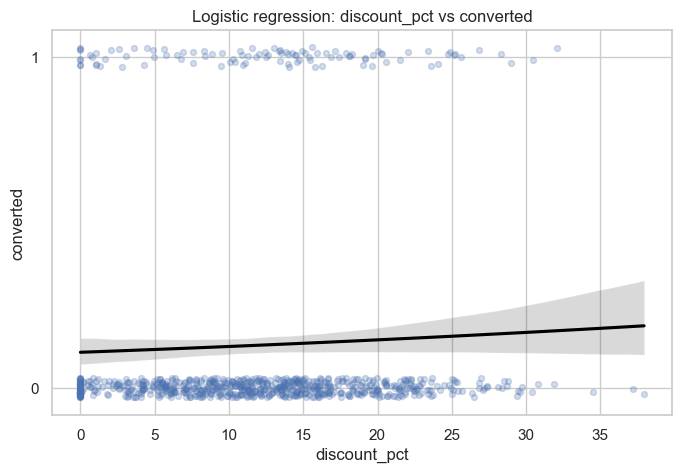

In [9]:
# Logistic regression: discount_pct vs converted
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x='discount_pct',
    y='converted',
    logistic=True,
    y_jitter=0.03,
    scatter_kws={'alpha': 0.25, 's': 18},
    line_kws={'color': 'black'}
)
plt.title('Logistic regression: discount_pct vs converted')
plt.yticks([0, 1])
plt.show()


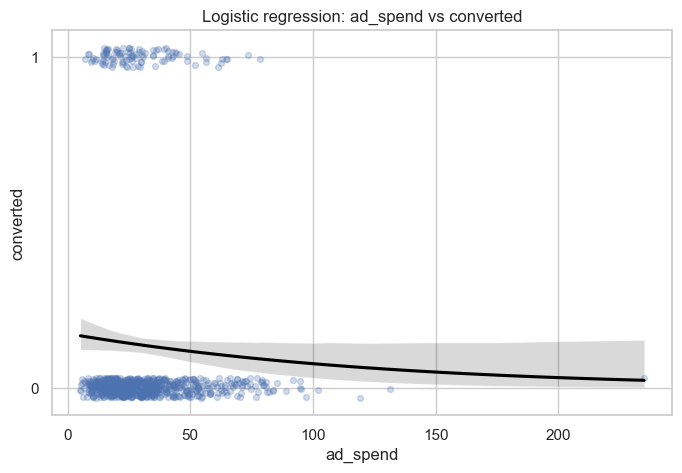

In [10]:
# Logistic regression: ad_spend vs converted
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x='ad_spend',
    y='converted',
    logistic=True,
    y_jitter=0.03,
    scatter_kws={'alpha': 0.25, 's': 18},
    line_kws={'color': 'black'}
)
plt.title('Logistic regression: ad_spend vs converted')
plt.yticks([0, 1])
plt.show()


## 5) Conditioning regression (`lmplot`)
`lmplot()` is a **figure-level** function (built on `FacetGrid`).

Why use it?
- Easily fit separate regression lines per category (`hue=...`) or per facet (`col=...`, `row=...`).
- Very useful for e-commerce because relationships often differ by channel, device, or customer segment.

Tip: Because `lmplot` creates its own figure, style it with its parameters (`height`, `aspect`) and avoid mixing with `plt.figure()`.


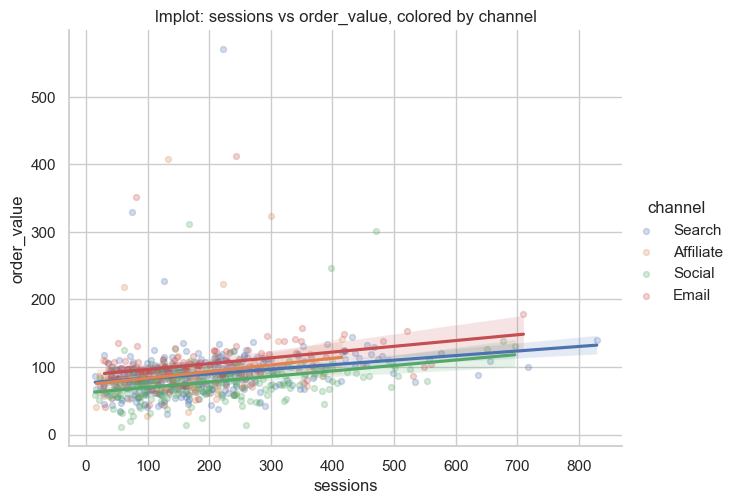

In [11]:
# lmplot: relationship differs by channel
sns.lmplot(
    data=df,
    x='sessions',
    y='order_value',
    hue='channel',
    height=5,
    aspect=1.3,
    scatter_kws={'alpha': 0.25, 's': 18}
)
plt.title('lmplot: sessions vs order_value, colored by channel')
plt.show()


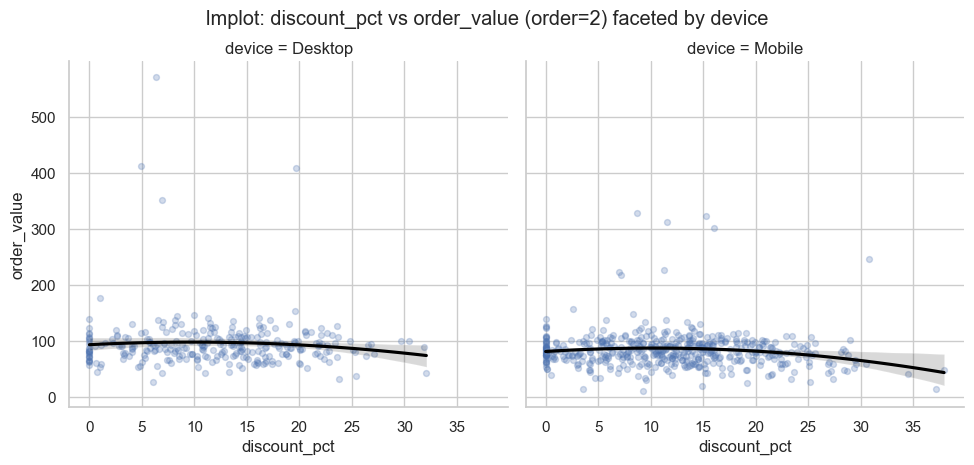

In [12]:
# lmplot with faceting: separate panels per device
sns.lmplot(
    data=df,
    x='discount_pct',
    y='order_value',
    col='device',
    order=2,
    height=4.5,
    aspect=1.1,
    scatter_kws={'alpha': 0.25, 's': 18},
    line_kws={'color': 'black'}
)
plt.suptitle('lmplot: discount_pct vs order_value (order=2) faceted by device', y=1.03)
plt.show()


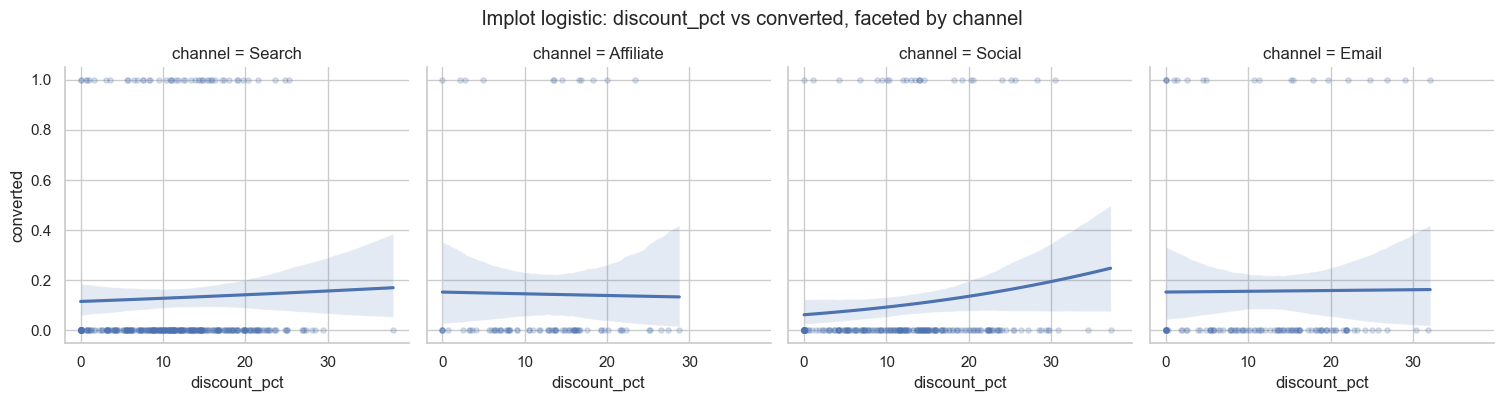

In [13]:
# lmplot logistic by channel (conversion vs discount)
# Note: logistic regression is meaningful here because y is binary.
sns.lmplot(
    data=df,
    x='discount_pct',
    y='converted',
    col='channel',
    logistic=True,
    height=3.8,
    aspect=1.0,
    scatter_kws={'alpha': 0.20, 's': 14}
)
plt.suptitle('lmplot logistic: discount_pct vs converted, faceted by channel', y=1.05)
plt.show()


---
## Practice set (recommended)
Use the synthetic `df` created above.

### A) Linear regression
1. Plot `regplot(x='sessions', y='revenue')` with and without confidence intervals (`ci=None`).
2. Try log-scaling x: create `df['log_spend'] = np.log1p(df['ad_spend'])` and fit `regplot(x='log_spend', y='revenue')`.

### B) Residual diagnostics
3. Plot `residplot(x='discount_pct', y='order_value')`. Do you see curvature?
4. Compare residuals for `order=1` vs `order=2` by manually creating predictions (challenge).

### C) Robust vs standard
5. Plot `regplot(x='sessions', y='order_value')` and `regplot(..., robust=True)` side-by-side.

### D) Logistic
6. Plot a logistic curve for `converted` vs `sessions`.

### E) Conditioning
7. Use `lmplot` to model `ad_spend` vs `revenue` with `hue='device'`.
8. Facet `sessions` vs `order_value` by `channel` using `col='channel'`.

### Challenge
9. Create a small function `plot_reg_and_resid(df, x, y, **kwargs)` that makes a 1x2 figure:
   left = regplot, right = residplot.


In [14]:
# Practice template (fill TODOs)

# TODO A1-A2

# TODO B3-B4

# TODO C5

# TODO D6

# TODO E7-E8

from typing import Any

def plot_reg_and_resid(df: pd.DataFrame, x: str, y: str, **kwargs: Any):
    # TODO: 1x2 layout: regplot + residplot
    pass


## Reference links
- Seaborn regression tutorial: https://seaborn.pydata.org/tutorial/regression.html
- `regplot` API: https://seaborn.pydata.org/generated/seaborn.regplot.html
- `residplot` API: https://seaborn.pydata.org/generated/seaborn.residplot.html
- `lmplot` API: https://seaborn.pydata.org/generated/seaborn.lmplot.html
